In [ ]:
%load_ext autoreload
%autoreload 2

# Datalink
# https://polybox.ethz.ch/index.php/s/d0FWhtqYRHpSwra?path=%2F

import os
import datetime
import numpy as np 
import matplotlib.pyplot as plt

#os.chdir('../'); print(os.getcwd())
os.chdir('/Users/edouardpaupe/Desktop/magnify-main_DATABASE')
print(os.getcwd())

from src.utils import (
                        get_list_of_buildings,#parses building folder names to create a table of building attributes (type, age, climate, id, folder).
                        load_armax_model,
                        load_weather_data,
                        add_solar_bins,
                        prepare_weather_data,
                        get_weather_forecasts,
                        plot_weather_forecasts,
                        plot_episode,
                        )
from src.env import Env
from src.agents import RB, MPC

from src.flex import (plot_power_bounds_for_episode,
                      extract_daily_zone_bounds,
                      power_to_energy_bounds,
                      max_duration_for_constant_power,
                      slice_for_episode,
                      envelope_for_zone_day,
                      )

/Users/edouardpaupe/Desktop/magnify-main


Flexibility UB and LB with Rule-Based Controller

In [2]:
# Initialize the environment for the flexibility computation
env = Env(
    building_id='ep_SFH_age_0_climate_0_1241',  # Select building archetype, there are 30 in total
    climate_id=0,                               # Climate scenario, there are 6 in total, each climate_id starts on 2020-01-02
    start_time=datetime.datetime(2020, 1, 2, 0, 0, 0),  # Simulation start: year, month, day, hour, minute, second
    end_time=datetime.datetime(2020, 1, 3, 0, 0, 0),   # Simulation end: year, month, day, hour, minute, second
    history_hours=8,                            # Past data provided to agent
    horizon_hours=24,                           # Future forecast provided to agent
    steps_per_hour=4,                           # Time discretization (15 min)
)
# Reset the environment to get initial observations
observations, _ = env.reset()

# Initialize the rule-based controller (RB) for comfort control during bounds computation
controller = RB(
    n_zones=env.n_zones,
    T_min=20.0,  # Minimum comfort temperature
    T_max=22.0   # Maximum comfort temperature
)

# Initialize the upper bound MPC controller (maximal heating/flexibility)
upper_bound = MPC(
    armax_config=env.armax_config,
    target_temperature=21.0,
    T_min=np.full((env.horizon_length  + 1, env.n_zones), 20),  # Lower comfort bound
    T_max=np.full((env.horizon_length  + 1, env.n_zones), 22.0),# Upper comfort bound
    history_length=env.history_length,
    horizon_length=env.horizon_length,
    objective='upper_bound'  # Objective for upper flexibility bound
)

# Initialize the lower bound MPC controller (minimal heating/flexibility)
lower_bound = MPC(
    armax_config=env.armax_config,
    target_temperature=21.0,
    T_min=np.full((env.horizon_length  + 1, env.n_zones), 20),
    T_max=np.full((env.horizon_length  + 1, env.n_zones), 22.0),
    history_length=env.history_length,
    horizon_length=env.horizon_length,
    objective='lower_bound'  # Objective for lower flexibility bound
)

In [3]:
# Lists to store computation times for each bound
time_upp = []
time_low = []

# Main loop: run until the environment signals termination
while not env.terminated:
    # Compute upper bound (maximal flexibility) and record computation time
    t_upp = datetime.datetime.now()
    upper_bound.predict(observations)
    time_upp.append((datetime.datetime.now() - t_upp).total_seconds())

    # Compute lower bound (minimal flexibility) and record computation time
    t_low = datetime.datetime.now()
    lower_bound.predict(observations)
    time_low.append((datetime.datetime.now() - t_low).total_seconds())

    # Save the results of the current episode for both bounds
    upper_bound.save_episode()
    lower_bound.save_episode()
    
    # Use the rule-based controller to select actions for the next step
    actions = controller.predict(observations)
    observations, reward, _, done, _ = env.step(actions)  # Advance environment

# Print average computation times for upper and lower bound MPCs
print(f'Upper bound computation time: {np.mean(time_upp):.3f} seconds')
print(f'Lower bound computation time: {np.mean(time_low):.3f} seconds')

Upper bound computation time: 0.111 seconds
Lower bound computation time: 0.117 seconds


In [4]:
# Heat pump nominal power [kW]
hp_power = 1  

# Number of episodes simulated
n_episodes = len(upper_bound.results["control_action"])

# Horizon length (number of lead times)
horizon_length = env.horizon_length

# Number of thermal zones
n_zones = env.n_zones

# Initialize 3D arrays: (zones, episodes, horizon)
upper_power_bound = np.zeros((n_zones, n_episodes, horizon_length))
lower_power_bound = np.zeros((n_zones, n_episodes, horizon_length))

# Loop over all episodes
for t in range(n_episodes):
    # Extract upper and lower valve openings for all zones
    # shape = (time_steps, n_zones)
    u_upp = np.array([list(x.values()) for x in upper_bound.results["control_action"][t].values()])
    u_low = np.array([list(x.values()) for x in lower_bound.results["control_action"][t].values()])

    # Keep only prediction horizon (exclude history)
    u_upp = u_upp[env.history_length:, :]  # shape (horizon_length, n_zones)
    u_low = u_low[env.history_length:, :]

    # Transpose so that zones are the first axis
    # (n_zones, horizon_length)
    u_upp = u_upp.T
    u_low = u_low.T

    # Convert to power and store
    upper_power_bound[:, t, :] = u_upp * hp_power
    lower_power_bound[:, t, :] = u_low * hp_power

print("Upper power bound shape:", upper_power_bound.shape)  # (n_zones, n_episodes, horizon_length)
print("Lower power bound shape:", lower_power_bound.shape)


Upper power bound shape: (5, 96, 96)
Lower power bound shape: (5, 96, 96)


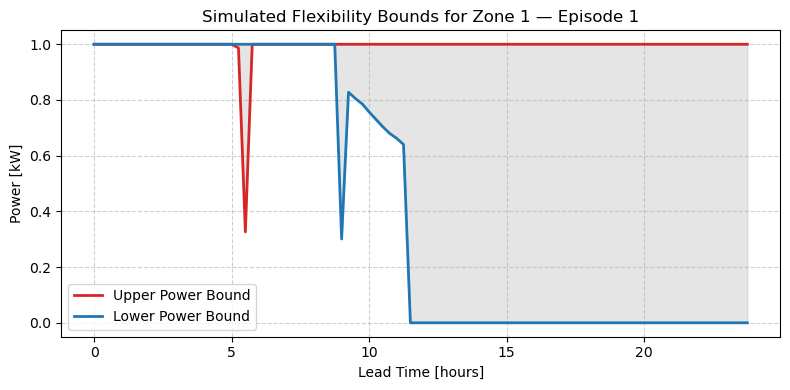

In [7]:
# Example: visualize zone j during the ith MPC run
zone_id = 0        # goes from 0 to n_zones-1 
episode_id = 0      # ith MPC run, e.g. 9 for the 10th run, goes from 0 to n_episodes-1
plot_power_bounds_for_episode(upper_power_bound, lower_power_bound, zone_id, episode_id, env)

In [6]:
# bounds_dict = extract_daily_zone_bounds(
#     upper_power_bound,
#     lower_power_bound,
#     env,
#     save_dir="/Users/edouardpaupe/Desktop/magnify-main/data/power_bounds/"
# )